___
**EDA** 

IvanMF888
___

In [18]:
# Librerias 
import pandas as pd
import numpy as np 
import string
import hashlib
import os

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Necesario para ver tablas


# Configuración de estilos para los gráficos
sns.set_theme(style="whitegrid")

# 1. CARGA DE DATOS PROCESADOS (No Raw)
# Buscamos el archivo que generó tu ETL
ruta_procesada = os.path.join("..", "data", "processed", "Base_ContactCenter_Master.csv")

print(f"📂 Cargando datos desde: {ruta_procesada}...")

if os.path.exists(ruta_procesada):
    df_procesado = pd.read_csv(ruta_procesada)
    
    # 2. AJUSTE DE TIPOS DE DATOS
    # Al cargar de CSV, las fechas se vuelven texto, hay que reconvertirlas
    df_procesado['Fecha'] = pd.to_datetime(df_procesado['Fecha'], dayfirst=True, errors='coerce')


    print(f"✅ Carga exitosa. Dimensiones: {df_procesado.shape}")
    display(df_procesado.head())
    print("\nTipos de datos:")
    print(df_procesado.dtypes)
else:
    print("❌ ERROR: No encuentro el archivo procesado.")
    print("   -> Asegúrate de haber corrido '01_ETL.ipynb' primero.")
    print("   -> Verifica que la carpeta 'data/processed' exista.")


📂 Cargando datos desde: ..\data\processed\Base_ContactCenter_Master.csv...
✅ Carga exitosa. Dimensiones: (2646416, 26)


,Fecha,Tiempo Inicio,Llamadas Recibidas,Llamadas abandonas,Llamadas Atendidas,Tiempo Total Ring,Tiempo Total de Conversación,Tiempo Total Hold,Tiempo Total ACW,Tiempo Total Avail,...,AUX 6 RETRO_CALIDAD,AUX 7 MEETING,AUX 8 PERSONALES,AUX 9 FALLA APLICATIVO,Agente_ID,Skill_ID,Total_Handle_Time,AHT,Hora,Turno
0,2024-01-01,09:00,0,0,0,0,0,0,0,1661,...,0,0,0,0,Agente_0001,Skill_A,0,0.0,9,Matutino
1,2024-01-01,09:30,0,0,0,0,0,0,0,1800,...,0,0,0,0,Agente_0001,Skill_A,0,0.0,9,Matutino
2,2024-01-01,10:00,0,0,0,0,0,0,0,1800,...,0,0,0,0,Agente_0001,Skill_A,0,0.0,10,Matutino
3,2024-01-01,10:30,0,0,0,0,0,0,0,1800,...,0,0,0,0,Agente_0001,Skill_A,0,0.0,10,Matutino
4,2024-01-01,11:00,0,0,0,0,0,0,0,451,...,0,0,133,0,Agente_0001,Skill_A,0,0.0,11,Matutino



Tipos de datos:
Fecha                           datetime64[ns]
Tiempo Inicio                           object
Llamadas Recibidas                       int64
Llamadas abandonas                       int64
Llamadas Atendidas                       int64
Tiempo Total Ring                        int64
Tiempo Total de Conversación             int64
Tiempo Total Hold                        int64
Tiempo Total ACW                         int64
Tiempo Total Avail                       int64
AUX 0 DEFAULT SYSTEMA                    int64
AUX 1 ADMINISTRACION                     int64
AUX 2 MEDICO                             int64
AUX 3 BREAK_COMIDA                       int64
RETRO_CAPACITACION                       int64
AUX 5 RETRO_OPERACION                    int64
AUX 6 RETRO_CALIDAD                      int64
AUX 7 MEETING                            int64
AUX 8 PERSONALES                         int64
AUX 9 FALLA APLICATIVO                   int64
Agente_ID                               obj

___
**Visualizaciones EDA**


In [19]:
df_procesado['Turno'].unique()
df_procesado['Turno'].value_counts()

Turno
Matutino      1721945
Vespertino     924471
Name: count, dtype: int64

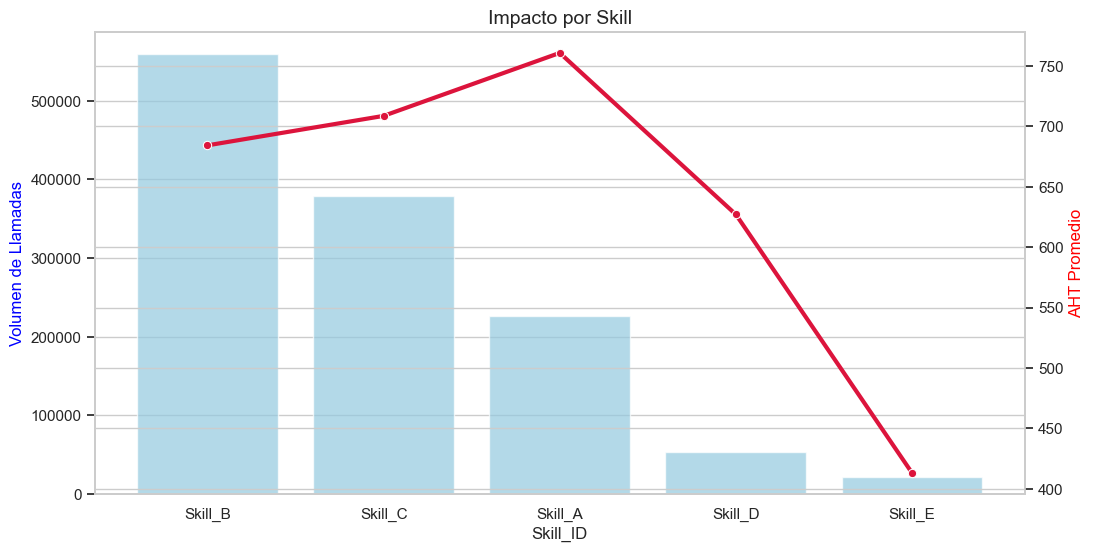

,Skill_ID,Volumen,AHT
1,Skill_B,559767,684.141087
2,Skill_C,378545,708.515413
0,Skill_A,226895,760.606007
3,Skill_D,52763,626.951614
4,Skill_E,21247,413.202664


In [20]:
plt.figure(figsize=(12, 6))

# Agrupa los datos por identificador de skill para consolidar métricas operativas por categoría
skill_stats = df_procesado.groupby('Skill_ID').agg(
    Volumen=('Llamadas Atendidas', 'sum'),
    # Calcula el AHT ponderado dividiendo el tiempo total entre el total de llamadas para evitar el sesgo del promedio de promedios
    AHT=('Total_Handle_Time', lambda x: x.sum() / df_procesado.loc[x.index, 'Llamadas Atendidas'].sum())
).reset_index()

# Prioriza las categorías con mayor carga operativa para facilitar la identificación de los focos de atención principales
skill_stats = skill_stats.sort_values('Volumen', ascending=False)

# Implementa un gráfico de barras para representar la magnitud absoluta del volumen por cada skill
ax1 = sns.barplot(data=skill_stats, x='Skill_ID', y='Volumen', color='skyblue', alpha=0.7)

# Crea un eje secundario compartido para superponer la métrica de tiempo (AHT) sin distorsionar la escala del volumen
ax2 = ax1.twinx()
# Utiliza una línea con marcadores para resaltar la tendencia de eficiencia sobre las barras de volumen
sns.lineplot(data=skill_stats, x='Skill_ID', y='AHT', color='crimson', marker='o', linewidth=3, ax=ax2)

# Configuración de etiquetas para diferenciar claramente las dos unidades de medida (cantidad vs. tiempo)
ax1.set_ylabel('Volumen de Llamadas', color='blue')
ax2.set_ylabel('AHT Promedio', color='red')
plt.title('Impacto por Skill', fontsize=14)
plt.show()

# Muestra el resumen tabular para permitir una auditoría precisa de los valores representados en el gráfico
display(skill_stats)

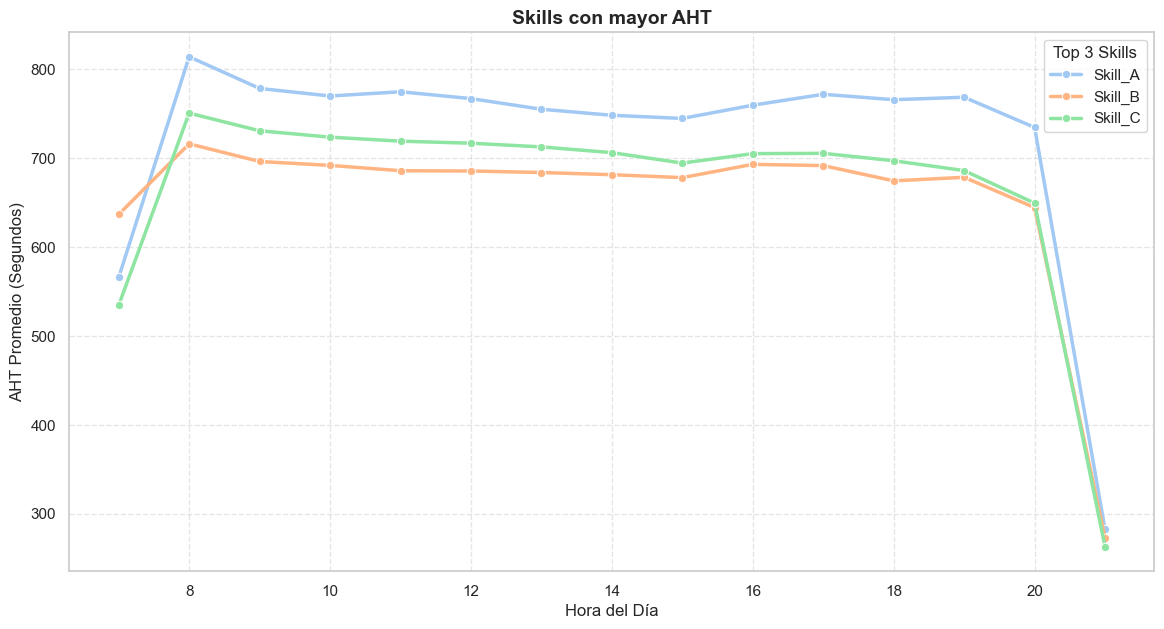

📊 Resumen de Complejidad:
   -> Skill_A: AHT Promedio Global de 133 seg
   -> Skill_B: AHT Promedio Global de 291 seg
   -> Skill_C: AHT Promedio Global de 213 seg


In [21]:
plt.figure(figsize=(14, 7))

# Selecciona las tres categorías con mayor frecuencia para evitar la saturación visual y centrar el análisis en los grupos más representativos.
top_skills = df_procesado['Skill_ID'].value_counts().head(3).index.tolist()

# Restringe el conjunto de datos únicamente a los identificadores seleccionados previamente.
df_top_skills = df_procesado[df_procesado['Skill_ID'].isin(top_skills)]

# Consolida las métricas operativas por hora y categoría para permitir el cálculo de promedios ponderados.
perfil_skill = df_top_skills.groupby(['Hora', 'Skill_ID'])[['Total_Handle_Time', 'Llamadas Atendidas']].sum().reset_index()

# Calcula el Average Handle Time (AHT) como el ratio de eficiencia por cada interacción.
perfil_skill['AHT_Skill'] = perfil_skill['Total_Handle_Time'] / perfil_skill['Llamadas Atendidas']

# Representa la evolución temporal del AHT diferenciando cada categoría mediante una serie independiente.
sns.lineplot(data=perfil_skill, x='Hora', y='AHT_Skill', hue='Skill_ID', marker='o', linewidth=2.5, palette='pastel')

# Configuración de elementos de soporte visual para facilitar la interpretación de escalas y tendencias.
plt.title('Skills con mayor AHT', fontsize=14, fontweight='bold')
plt.ylabel('AHT Promedio (Segundos)')
plt.xlabel('Hora del Día')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Top 3 Skills')

plt.show()

# Genera un resumen cuantitativo para contrastar los resultados visuales con métricas globales.
print("📊 Resumen de Complejidad:")
for skill in top_skills:
    # Calcula la media aritmética del AHT para el skill actual dentro del subconjunto filtrado.
    aht_promedio = df_top_skills[df_top_skills['Skill_ID'] == skill]['AHT'].mean()
    print(f"   -> {skill}: AHT Promedio Global de {int(aht_promedio)} seg")

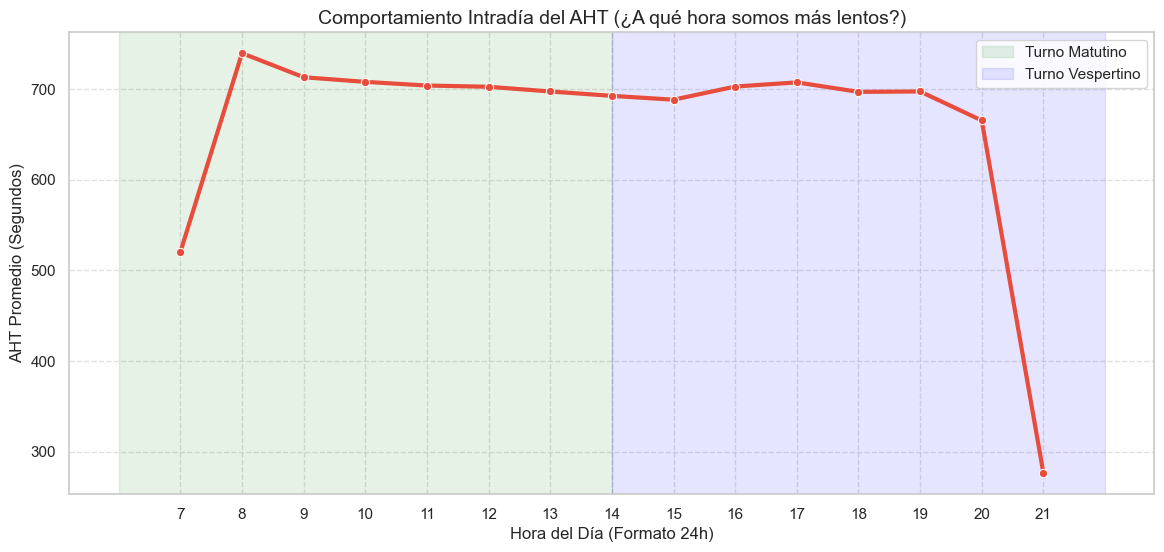

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define las dimensiones del lienzo para asegurar legibilidad en series temporales extensas
plt.figure(figsize=(14, 6))

# Agrupamos métricas base por hora para calcular promedios ponderados posteriormente
perfil_horario = df_procesado.groupby('Hora')[['Total_Handle_Time', 'Llamadas Atendidas']].sum()

# El AHT (Average Handle Time) se obtiene dividiendo el tiempo total de gestión entre el volumen de atención
perfil_horario['AHT_Hora'] = perfil_horario['Total_Handle_Time'] / perfil_horario['Llamadas Atendidas']
perfil_horario = perfil_horario.reset_index()

# Filtramos horas con tráfico marginal para evitar que valores atípicos distorsionen la tendencia visual
perfil_horario = perfil_horario[perfil_horario['Llamadas Atendidas'] > 100] 

# Representamos la evolución temporal del AHT mediante un gráfico de líneas para identificar picos de ineficiencia
sns.lineplot(data=perfil_horario, x='Hora', y='AHT_Hora', marker='o', linewidth=3, color='#e74c3c')

# Delimitamos visualmente los turnos operativos para correlacionar el rendimiento con los cambios de personal
plt.axvspan(6, 14, color='green', alpha=0.1, label='Turno Matutino')
plt.axvspan(14, 22, color='blue', alpha=0.1, label='Turno Vespertino')

plt.title('Comportamiento Intradía del AHT (¿A qué hora somos más lentos?)', fontsize=14)
plt.ylabel('AHT Promedio (Segundos)')
plt.xlabel('Hora del Día (Formato 24h)')

# Forzamos la visualización de cada hora en el eje X para facilitar la lectura puntual
plt.xticks(range(min(perfil_horario['Hora']), max(perfil_horario['Hora'])+1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

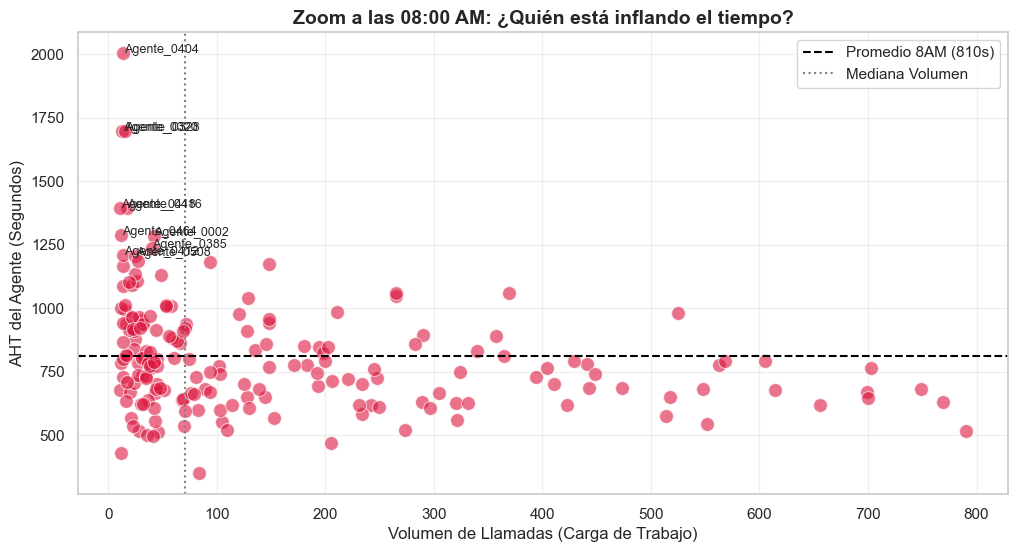

📊 Análisis de las 08:00 AM:
   -> Agentes analizados: 190
   -> AHT Promedio en esta hora: 810 seg
   -> Peor Agente (Lento): Agente_0404 con 2004 seg


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define las dimensiones del lienzo para asegurar la legibilidad de las etiquetas y puntos
plt.figure(figsize=(12, 6))

# Selecciona el subconjunto de datos correspondiente a la hora crítica para investigar anomalías en el rendimiento
df_peak = df_procesado[df_procesado['Hora'] == 8]

# Consolida las métricas operativas por individuo para comparar el desempeño relativo entre agentes
agent_peak = df_peak.groupby('Agente_ID')[['Total_Handle_Time', 'Llamadas Atendidas']].sum()
# Calcula el tiempo promedio de atención (AHT) como indicador clave de eficiencia
agent_peak['AHT_8AM'] = agent_peak['Total_Handle_Time'] / agent_peak['Llamadas Atendidas']
# Aplica un umbral de representatividad estadística para descartar sesgos por bajo volumen de datos
agent_peak = agent_peak[agent_peak['Llamadas Atendidas'] > 10] 

# Representa la correlación entre la carga de trabajo y la velocidad de resolución para detectar saturación
sns.scatterplot(data=agent_peak, x='Llamadas Atendidas', y='AHT_8AM', alpha=0.6, s=100, color='crimson')

# Establece el punto de referencia central para identificar quiénes operan fuera de la norma del equipo
promedio_hora = agent_peak['AHT_8AM'].mean()
plt.axhline(y=promedio_hora, color='black', linestyle='--', label=f'Promedio 8AM ({int(promedio_hora)}s)')
# Divide el gráfico en cuadrantes de productividad mediante la mediana de volumen
plt.axvline(x=agent_peak['Llamadas Atendidas'].median(), color='grey', linestyle=':', label='Mediana Volumen')

plt.title('Zoom a las 08:00 AM: ¿Quién está inflando el tiempo?', fontsize=14, fontweight='bold')
plt.xlabel('Volumen de Llamadas (Carga de Trabajo)')
plt.ylabel('AHT del Agente (Segundos)')
plt.legend()
plt.grid(True, alpha=0.3)

# Aísla casos con tiempos de atención excesivos que impactan negativamente en el SLA
outliers = agent_peak[agent_peak['AHT_8AM'] > 1200]
# Etiqueta dinámicamente los puntos críticos en el gráfico para facilitar la identificación inmediata de los agentes
for agent_id, row in outliers.iterrows():
    plt.text(row['Llamadas Atendidas']+0.5, row['AHT_8AM'], agent_id, fontsize=9)

plt.show()

# Genera métricas de resumen para validar la magnitud de la desviación detectada
print(f"📊 Análisis de las 08:00 AM:")
print(f"   -> Agentes analizados: {len(agent_peak)}")
print(f"   -> AHT Promedio en esta hora: {int(promedio_hora)} seg")
print(f"   -> Peor Agente (Lento): {agent_peak['AHT_8AM'].idxmax()} con {int(agent_peak['AHT_8AM'].max())} seg")

In [24]:
# Verifica qué horas existen realmente en tu base
print("Horas encontradas:", df_procesado['Hora'].unique())

# Verifica cuánta gente tienes a las 8 AM
fila_8am = len(df_procesado[df_procesado['Hora'] == 8])
print(f"Registros a las 8 AM: {fila_8am}")


Horas encontradas: [ 9 10 11 12 13 14 15  8  7 16 17 18 19 20 21 22]
Registros a las 8 AM: 120470


In [25]:
# ||------------------------------------------------------------||
# 6. ANÁLISIS DE IMPACTO (La Recomendación de Negocio)

# Establece el límite de tiempo en segundos para identificar ineficiencias operativas.
UMBRAL_CRITICO = 1000 
# Define la franja horaria específica donde se ha detectado la mayor desviación de rendimiento.
HORA_CRITICA = 8

# Segmenta el conjunto de datos para aislar el comportamiento de la hora seleccionada.
df_8am = df_procesado[df_procesado['Hora'] == HORA_CRITICA].copy()

# Consolida métricas por agente para normalizar el cálculo del AHT individual.
agentes_8am = df_8am.groupby('Agente_ID')[['Total_Handle_Time', 'Llamadas Atendidas']].sum()
# Calcula el tiempo promedio de atención real por agente en este bloque horario.
agentes_8am['AHT_Real'] = agentes_8am['Total_Handle_Time'] / agentes_8am['Llamadas Atendidas']

# 2. IDENTIFICAR LOS "OUTLIERS" (Los que necesitan capacitación)
# Filtra agentes con bajo rendimiento que posean una muestra representativa (más de 5 llamadas)
# para evitar sesgos por casos aislados o errores de registro.
coaching_list = agentes_8am[
    (agentes_8am['AHT_Real'] > UMBRAL_CRITICO) & 
    (agentes_8am['Llamadas Atendidas'] > 5)
].sort_values('AHT_Real', ascending=False)

print(f"🚨 ALERTAS DETECTADAS: {len(coaching_list)} agentes críticos a las {HORA_CRITICA}:00 horas.")
display(coaching_list)

# 3. ESCENARIO "WHAT-IF" (¿Qué pasa si los capacitamos?)
# Determina el rendimiento base actual de la operación para medir el impacto de la mejora.
aht_actual_global = df_8am['Total_Handle_Time'].sum() / df_8am['Llamadas Atendidas'].sum()

# Define el objetivo de rendimiento esperado tras la intervención de capacitación.
aht_promedio_meta = 720
# Cuantifica el tiempo total consumido actualmente por el grupo de agentes críticos.
tiempo_excesivo = coaching_list['Total_Handle_Time'].sum()
# Estima el tiempo que este mismo grupo consumiría si operaran bajo el estándar meta.
tiempo_simulado = coaching_list['Llamadas Atendidas'].sum() * aht_promedio_meta

# Ajusta el total de tiempo de la operación reemplazando el tiempo ineficiente por el proyectado.
nuevo_tiempo_total = df_8am['Total_Handle_Time'].sum() - tiempo_excesivo + tiempo_simulado
# Recalcula el indicador global para visualizar el beneficio neto en la operación.
nuevo_aht_global = nuevo_tiempo_total / df_8am['Llamadas Atendidas'].sum()

# Resultados
mejora = aht_actual_global - nuevo_aht_global
print(f"\n💰 IMPACTO DE NEGOCIO:")
print(f"   -> AHT Actual a las 8 AM: {aht_actual_global:.2f} seg")
print(f"   -> AHT Proyectado (Post-Capacitación): {nuevo_aht_global:.2f} seg")
print(f"   -> MEJORA POTENCIAL: -{mejora:.2f} segundos en el promedio global.")

🚨 ALERTAS DETECTADAS: 39 agentes críticos a las 8:00 horas.


,Total_Handle_Time,Llamadas Atendidas,AHT_Real
Agente_ID,,,
Agente_0404,28068,14,2004.857143
Agente_0328,25470,15,1698.000000
Agente_0320,22064,13,1697.230769
Agente_0536,14069,9,1563.222222
Agente_0415,13305,9,1478.333333
Agente_0106,10007,7,1429.571429
Agente_0416,23726,17,1395.647059
Agente_0418,15327,11,1393.363636
Agente_0464,15466,12,1288.833333



💰 IMPACTO DE NEGOCIO:
   -> AHT Actual a las 8 AM: 739.45 seg
   -> AHT Proyectado (Post-Capacitación): 714.25 seg
   -> MEJORA POTENCIAL: -25.19 segundos en el promedio global.


___

C:\Users\Ivan Die\AppData\Local\Temp\ipykernel_10228\958981418.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ranking_plot.index, y=ranking_plot['AHT_Agente'], palette=colors)


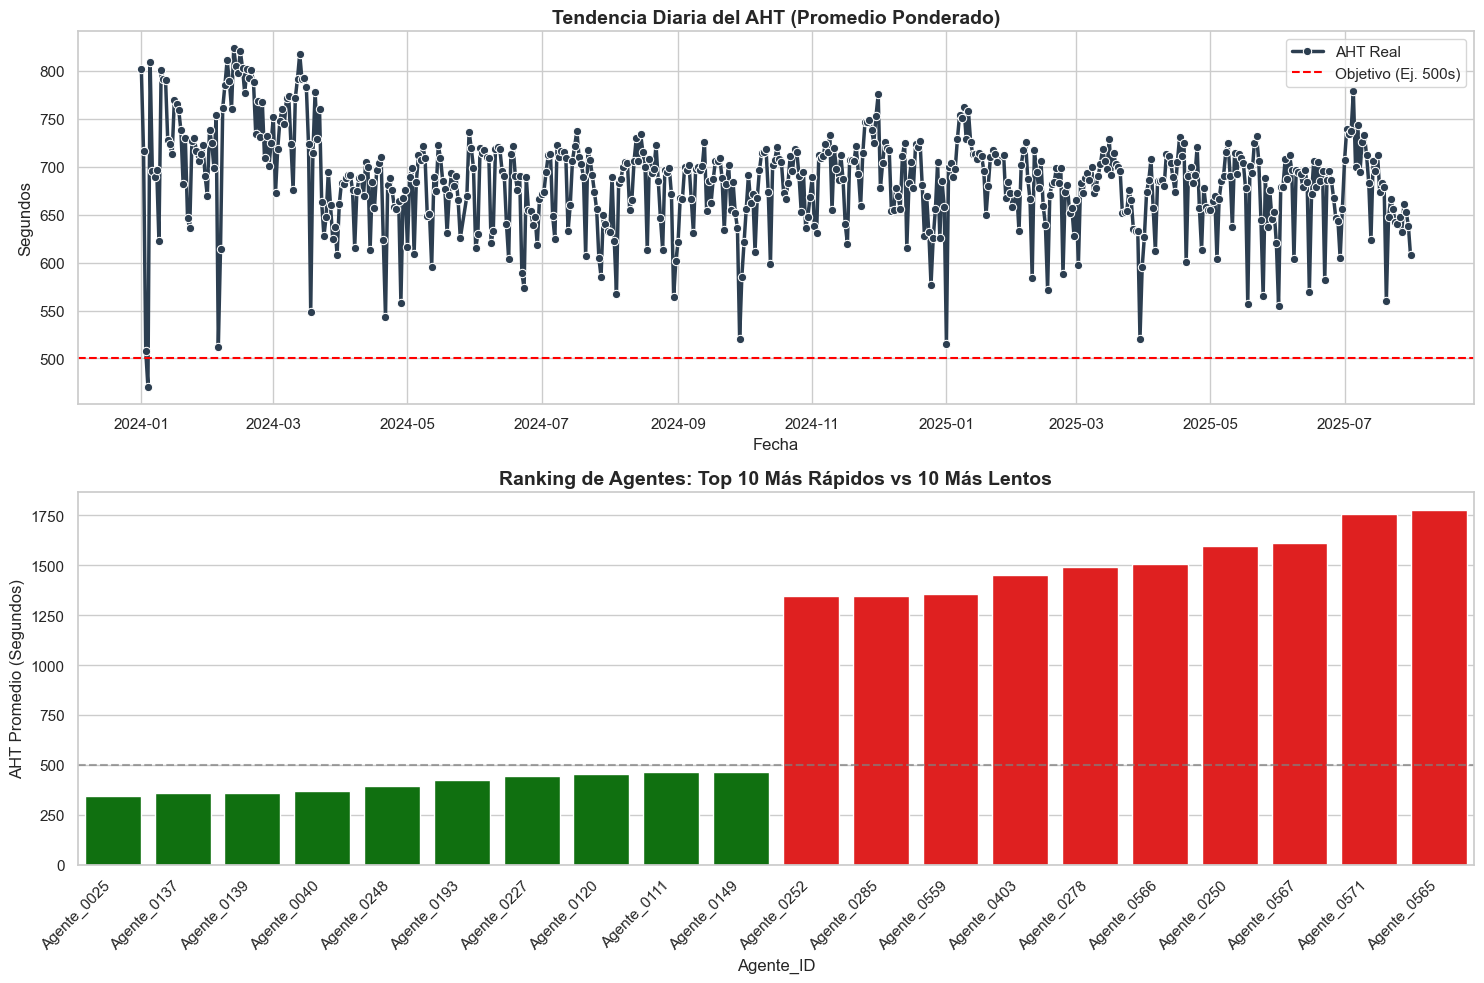

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establece una estética visual limpia y define el tamaño del lienzo para albergar múltiples gráficos
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))

# ||------------------------------------------------------------||
# GRÁFICO 1: TENDENCIA DIARIA (AHT Real vs Objetivo)
# Agrupamos por fecha sumando los tiempos y las llamadas (Promedio Ponderado)
# Se suman los totales antes de dividir para evitar el sesgo estadístico de promediar promedios diarios
daily_kpis = df_procesado.groupby('Fecha')[['Total_Handle_Time', 'Llamadas Atendidas']].sum()
daily_kpis['AHT_Dia'] = daily_kpis['Total_Handle_Time'] / daily_kpis['Llamadas Atendidas']
daily_kpis = daily_kpis.reset_index()

# Define la posición del primer gráfico en una cuadrícula de 2 filas y 1 columna
plt.subplot(2, 1, 1)
# Representación temporal para identificar picos de ineficiencia o mejoras en el tiempo
sns.lineplot(data=daily_kpis, x='Fecha', y='AHT_Dia', marker='o', linewidth=2.5, color="#2c3e50", label='AHT Real')

# Establece un umbral visual para comparar el rendimiento actual contra la meta de negocio
plt.axhline(y=500, color='red', linestyle='--', label='Objetivo (Ej. 500s)')

plt.title('Tendencia Diaria del AHT (Promedio Ponderado)', fontsize=14, fontweight='bold')
plt.ylabel('Segundos')
plt.legend()


# ||------------------------------------------------------------||
# GRÁFICO 2: TOP & BOTTOM PERFORMERS (¿Quién mueve la aguja?)
# Consolidamos métricas por agente para evaluar productividad individual
agent_kpis = df_procesado.groupby('Agente_ID')[['Total_Handle_Time', 'Llamadas Atendidas']].sum()
agent_kpis['AHT_Agente'] = agent_kpis['Total_Handle_Time'] / agent_kpis['Llamadas Atendidas']

# Filtro de significancia estadística: se excluyen agentes con pocas llamadas para evitar que 
# valores atípicos (outliers) por baja muestra distorsionen el ranking de rendimiento
agent_kpis = agent_kpis[agent_kpis['Llamadas Atendidas'] > 50].sort_values('AHT_Agente')

# Segmentación de los extremos de la distribución para identificar mejores prácticas y necesidades de capacitación
top_10 = agent_kpis.head(10)
bottom_10 = agent_kpis.tail(10)
ranking_plot = pd.concat([top_10, bottom_10])

plt.subplot(2, 1, 2)
# Codificación de color semántica: verde para eficiencia alta, rojo para eficiencia baja
colors = ['green']*10 + ['red']*10

sns.barplot(x=ranking_plot.index, y=ranking_plot['AHT_Agente'], palette=colors)
plt.title('Ranking de Agentes: Top 10 Más Rápidos vs 10 Más Lentos', fontsize=14, fontweight='bold')
plt.ylabel('AHT Promedio (Segundos)')
# Rotación de etiquetas para asegurar la legibilidad de los identificadores de agentes
plt.xticks(rotation=45, ha='right')
plt.axhline(y=500, color='grey', linestyle='--', alpha=0.7)

# Ajusta automáticamente el espaciado entre subplots para evitar solapamiento de textos
plt.tight_layout()
plt.show()